In [61]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.colors


In [62]:
def S(x):
    return np.tanh(x)

def network_rhs(t, y, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I):
    E = y[:25]
    I = y[25:]
    
    # Compute the summed inputs
    inp_E = wEE * E - wEI * I + P_E
    inp_I = wIE * E - wII * I + P_I
    
    # Nonlinear output
    H_E = S(inp_E)
    H_I = S(inp_I)
    
    # dE/dt, dI/dt
    dE = (-E + H_E) / tau_E
    dI = (-I + H_I) / tau_I
    
    return np.concatenate([dE, dI])

In [63]:
E_0 = np.random.rand(25)*2 -1  # Initial conditions for excitatory neurons
I_0 = np.random.rand(25)*2 -1  # Initial conditions for inhibitory neurons

y0 = np.concatenate((E_0, I_0))

t0, t1 = 0.0, 10      # start and end times
t_eval = np.linspace(t0, t1, 501)

# Time constants
tau_E = 1
tau_I = 1

# Synaptic weights
wEE, wEI = 15, 10
wIE, wII = 8, 1.0

# External inputs (can be scalars or arrays of shape (N,))
P_E = 1
P_I = 1

sol = solve_ivp(
    fun=network_rhs,
    t_span=(t0, t1),
    y0=y0,
    t_eval=t_eval,
    args=(tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I),
    method='RK45',
    vectorized=False
)

E_t = sol.y[:25, :]   # shape (N, len(t_eval))
I_t = sol.y[25:, :]

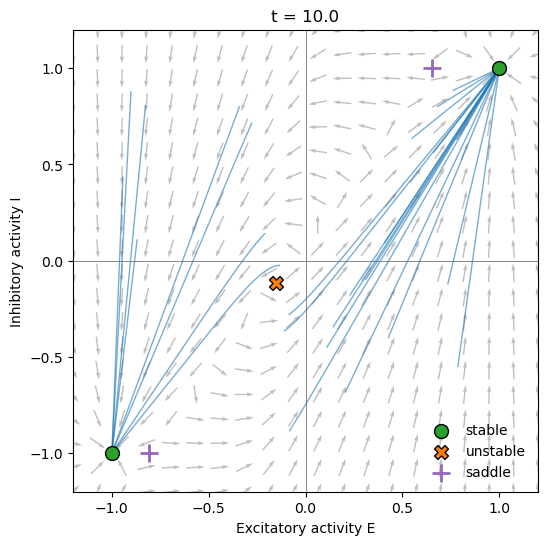

In [64]:
# ─── load or define your E_t, I_t, and t_eval ───
# E_t = sol.y[:N, :]    # shape (N, T)
# I_t = sol.y[N:, :]    # shape (N, T)
# t_eval = sol.t        # shape (T,)
N, T = E_t.shape

# ─── 1) Set up the figure ───
fig, ax = plt.subplots(figsize=(6,6))
scat = ax.scatter(
    E_t[:, 0], I_t[:, 0],
    c='C0', s=20, alpha=0.7
)
ax.set_xlim(E_t.min(), E_t.max())
ax.set_ylim(I_t.min(), I_t.max())
ax.set_xlabel('Excitatory activity E')
ax.set_ylabel('Inhibitory activity I')
ax.set_title(f't = {t_eval[0]:.1f}')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

# optional: draw a small reference line at the origin
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)

# ─── draw small reference line at origin ───
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)

# ─── after plotting scatter ───
trails = [
    ax.plot([], [], '-', lw=1, alpha=0.6, color = 'tab:blue')[0]
    for _ in range(N)
]

# ─── overlay phase‐flow arrows ───
# pick a coarse grid
nq = 20
E_grid = np.linspace(-1.2, 1.2, nq)
I_grid = np.linspace(-1.2, 1.2, nq)
EE, II = np.meshgrid(E_grid, I_grid)
# compute rhs at each grid point (for a single pair of E,I)
# here we ignore the other neurons and external inputs P_E, P_I
dE = (-EE + S(wEE*EE - wEI*II + P_E)) / tau_E
dI = (-II + S(wIE*EE - wII*II + P_I)) / tau_I
# normalize vectors
M = np.hypot(dE, dI)
M[M == 0] = 1.0  # avoid division by zero
dE /= M
dI /= M
# draw quiver
ax.quiver(EE, II, dE, dI,
          color='0.5', alpha=0.5, pivot='mid', scale=25, width=0.003)

from scipy.optimize import fsolve

# ─── 1) define the fixed‐point equations ───
def fixed_eqs(vars):
    E, I = vars
    return [
        E - np.tanh(wEE*E - wEI*I + P_E),
        I - np.tanh(wIE*E - wII*I + P_I)
    ]

# ─── 2) hunt for roots from a grid of initial guesses ───
inits = np.array(np.meshgrid(
    np.linspace(-1.2, 1.2, 7),
    np.linspace(-1.2, 1.2, 7)
)).T.reshape(-1,2)
fps = []
for guess in inits:
    root, info, ier, msg = fsolve(fixed_eqs, guess, full_output=True)
    if ier == 1:  # converged
        root = np.round(root, 6)
        if not any(np.allclose(root, fp, atol=1e-5) for fp in fps):
            fps.append(root)
fps = np.array(fps)

# ─── 3) classify each by Jacobian eigenvalues ───
stable_pts, unstable_pts, saddle_pts = [], [], []
for E_fp, I_fp in fps:
    u = wEE*E_fp - wEI*I_fp + P_E
    v = wIE*E_fp - wII*I_fp + P_I
    dSu = 1 - np.tanh(u)**2
    dSv = 1 - np.tanh(v)**2
    J = np.array([
        [(-1 + wEE*dSu)/tau_E,   (-wEI*dSu)/tau_E],
        [(wIE*dSv)/tau_I,        (-1 - wII*dSv)/tau_I]
    ])
    eigs = np.linalg.eigvals(J)
    if np.all(np.real(eigs) < 0):
        stable_pts.append((E_fp, I_fp))
    elif np.all(np.real(eigs) > 0):
        unstable_pts.append((E_fp, I_fp))
    else:
        saddle_pts.append((E_fp, I_fp))

# ─── 4) plot them ───
# stable → filled green circles
if stable_pts:
    sp = np.array(stable_pts)
    ax.scatter(sp[:,0], sp[:,1],
               marker='o', c='tab:green', s=100,
               edgecolor='k', label='stable', zorder=10)
# unstable → red X’s
if unstable_pts:
    up = np.array(unstable_pts)
    ax.scatter(up[:,0], up[:,1],
               marker='X', c='tab:orange', s=100,
               edgecolor='k', label='unstable', zorder=10)
# saddles → blue +’s
if saddle_pts:
    sad = np.array(saddle_pts)
    ax.scatter(sad[:,0], sad[:,1],
               marker='+', c='tab:purple', s=150,
               linewidths=2, label='saddle', zorder=10)

ax.legend(loc='best', frameon=False)


# ─── 2) Update function ───
def update(frame):
    coords = np.column_stack((E_t[:, frame], I_t[:, frame]))
    scat.set_offsets(coords)
    for i, line in enumerate(trails):
        line.set_data(E_t[i, :frame], I_t[i, :frame])
    ax.set_title(f't = {t_eval[frame]:.1f}')
    return [scat, *trails]

# ─── 3) Animate ───
interval = 50   # ms between frames
anim = FuncAnimation(
    fig, update, frames=T,
    interval=interval, blit=True
)

# ─── 4) Show or save ───
#plt.show()

# If you want to save to MP4 with FFMpegWriter:
anim.save('EI_phase_plane.mp4', dpi=150, fps=20)